# Import packages

In [1]:
import re
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load file

In [2]:
my_file = json.loads(open(r"comments_with_emoji_toarray.json", "r").read())
df = json_normalize(my_file)
print(df.head())
print(df.shape)

                                payload.comment.body
0  ## Step 2: Turn on GitHub Pages\n\nNicely done...
1  # [Codecov](https://codecov.io/gh/gitcoinco/we...
2  # [Codecov](https://codecov.io/gh/gitcoinco/we...
3  ## Nice work\n\n![celebrate](https://octodex.g...
4  # [Codecov](https://codecov.io/gh/poliastro/po...
(1104, 1)


# Extract comments into a list

In [3]:
list_of_comments = []
row_count = df.shape[0]
for i in range(row_count):
    list_of_comments.append(df['payload.comment.body'][i])
print(list_of_comments[0])

## Step 2: Turn on GitHub Pages

Nicely done @sromanowski12! At least one task in your Markdown to-do list is correct. :sparkles:

Now let's turn our focus to the content of your portfolio. Because this portfolio will be displayed as a static web page, you'll need to enable GitHub Pages.

### :keyboard: Activity: Enable GitHub Pages
1. Under your repository name, click [**Settings**](https://github.com/sromanowski12/markdown-portfolio/settings).
1. In the **GitHub Pages** section, use the **Select source** drop-down menu to select `master` as your GitHub Pages publishing source.
1. Click **Save**.

> _I may take up to a minute to respond as I wait for GitHub Pages to create a deployment of your repository_.

> _For more information, see [Configuring a publishing source for GitHub Pages](https://help.github.com/articles/configuring-a-publishing-source-for-github-pages/) in the GitHub Help._

<hr>
<h3 align="center">Return to this issue for next steps</h3>



# Extract emoji from each comment

In [4]:
# Find emoji
list_of_emoji = []
set_of_emoji = set()
for i in range(len(list_of_comments)):
    emoji = re.findall(":100:|:[^:\"|\s*|\[A-Z\]][a-z_]+[0-9]*:|:[+-]1:|:[a-z]+[0-9]*:", list_of_comments[i])
    # print(emoji)
    set_of_emoji.update(emoji)
    list_of_emoji.append(emoji)
    
print("__Set__")
print(set_of_emoji)
print("__List__")
print(list_of_emoji[:20])

__Set__
{':scream_cat:', ':keyboard:', ':no_entry:', ':di:', ':pencil2:', ':serverip:', ':trace:', ':other:', ':http:', ':no_entry_sign:', ':moneybag:', ':rotating_light:', ':authors:', ':0e:', ':x:', ':exclamation:', ':function:', ':sweat_smile:', ':emails:', ':confused:', ':disappointed:', ':point_down:', ':point_left:', ':man_shrugging:', ':heavy_check_mark:', ':wrench:', ':email:', ':smiling_imp:', ':executors:', ':green_heart:', ':rocket:', ':thumbsup:', ':ir:', ':octocat:', ':ip:', ':width:', ':wave:', ':detail:', ':man_facepalming:', ':bee:', ':pcsc_transmit:', ':https:', ':glide:', ':point_right:', ':filechooser:', ':heart:', ':4c:', ':gpioa:', ':worried:', ':logic_error:', ':object:', ':write:', ':@hint:', ':yp:', ':champagne:', ':bigthink:', ':runtime:', ':startup:', ':tada:', ':sc_unlock:', ':clock1:', ':page_facing_up:', ':string:', ':end:', ':sheepishly:', ':handle:', ':byond_version:', ':arrow_up:', ':json:', ':0b:', ':feaa:', ':yum:', ':grinning:', ':pcsc_internal_transm

# Clean up comments

In [5]:
# Remove emoji, URLs, commit SHAs, punctuation, extra whitespaces, convert to lowercase

processed = []
for i in range(len(list_of_comments)):
    comment_i = list_of_comments[i]
    # Emoji
    comment_i = re.sub(":100:|:[^:\"|\s*|\[A-Z\]][a-z_]+[0-9]*:|:[+-]1:|:[a-z]+[0-9]*:", "metaemoji", comment_i)
    # URLs
    comment_i = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "metaurl", comment_i)
    # Commit SHAs
    comment_i = re.sub("[a-zA-Z0-9]{40}", "metacommitsha", comment_i)
    # Punctuation
    comment_i = re.sub("[^\w\d\s]", " ", comment_i)
    # To lowercase
    comment_i = comment_i.lower()
    # Replace whitespace between terms with a single space
    comment_i = re.sub("\s+", " ", comment_i)
    # Remove leading and trailing whitespace
    comment_i = re.sub("^\s+|\s+?$", "", comment_i)
    processed.append(comment_i)

# print(processed)

In [6]:
# Tokenize, remove stop words, lemmatize

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
clean_comments = []

for i in range(len(processed)):
    tokenized_comment = word_tokenize(processed[i])
    clean = []
    for w in tokenized_comment:
        if w not in stop_words:
            lemmatizer.lemmatize(w)
            clean.append(w)
    clean = " ".join(clean)
    clean_comments.append(clean)

# print(clean_comments)

# Define positive, negative, and neutral emoji

In [7]:
# Positive emoji
pos_emoji = [":+1:", ":smile:", ":rocket:", ":confetti_ball:", ":laughing:", ":white_check_mark:",
             ":wink:", ":grinning:", ":wave:", ":exclamation:", ":fireworks:", ":ok_hand:", ":joy:",
             ":heart_eyes:", ":heart:", ":boom:", ":slightly_smiling_face:", ":sunglasses:", ":tada:",
             ":sparkles:", ":clap:", ":trollface:", ":stuck_out_tongue:", ":heavy_check_mark:",
             ":star:", ":grin:", ":blush:", ":see_no_evil:", ":sunny:", ":thumbsup:", ":cocktail:",
             ":yum:", ":relaxed:", ":champagne:", ":moneybag:", ":smile_cat:", ":green_heart:",
             ":sweat_smile:", ":smiling_imp:", ":crossed_fingers:", ":christmas_tree:", ":santa:",
             ":gift:", ":bulb:", ":smiley:", ":innocent:", ":vulkan:", ":trumpet:", ":upside_down_face:",
             ":bowing_man:"]

# Negative emoji
neg_emoji = [":cry:", "-1", ":fearful:", ":cold_sweat:", ":unamused:", ":confused:", ":angry:", ":rage:",
             ":shit:", ":sheepishly:", ":x:", ":no_entry:", ":no_entry_sign:", ":sob:", ":warning:",
             ":rotating_light:", ":bug:", ":man_facepalming:", ":woman_facepalming:", ":disappointed:",
             ":frowning_face:", ":roll_eyes:", ":worried:", ":panicking:", ":panic:", ":imp:"]

# Neutral emoji
neut_emoji = [":book:", ":muscle:", ":memo:", ":keyboard:", ":arrow_up:", ":arrow_down:", ":end:",
              ":robot:", ":wave:", ":abcd:", ":octocat:", ":recyccle:", ":neutral_face:", ":tv:",
              ":start:", ":pushpin:", ":hourglass:", ":tomato:", ":package:", ":phone:", ":pencil2:",
              ":scream_cat:", ":pray:", ":thinking:", ":bee:", ":point_right:", ":eyes:", ":bowtie:",
              ":wrench:", ":point_down:", ":pencil:", ":page_facing_up:", ":point_left:", ":green_apple:",
              ":clock10:", ":scroll:", ":hourglass:", ":umbrella:", ":email:", ":date:", ":bigthink:",
              ":construction:", ":construction_worker:", ":marker:", ":page_facing_up:", ":clock1:",
              ":man_shrugging:", ":new:", ":cat2:"]

# Calculate score of each comment based on emoji

In [8]:
emoji_classified = []
for i in range(len(list_of_emoji)):
    emoji_val = 0
    for j in range(len(list_of_emoji[i])):
        if list_of_emoji[i][j] in pos_emoji:
            emoji_val += 1
        elif list_of_emoji[i][j] in neg_emoji:
            emoji_val -= 1
        elif list_of_emoji[i][j] in neut_emoji:
            emoji_val += 0
        else:
            emoji_val += 0
    emoji_classified.append(emoji_val)

In [9]:
for i in range(len(emoji_classified)):
    if emoji_classified[i] > 0:
        emoji_classified[i] = 1
    elif emoji_classified[i] < 0:
        emoji_classified[i] = -1
    else:
        emoji_classified[i] = 0

# Create dataframe with cleaned comments and emoji score

In [10]:
emoji_data = {"comment": clean_comments, "emoji_score": emoji_classified}
final_df = pd.DataFrame(data=emoji_data)
final_df[:20]

,comment,emoji_score
0,step 2 turn github pages nicely done sromanows...,1
1,codecov metaurl report merging 3362 metaurl ma...,0
2,codecov metaurl report merging 3362 metaurl ma...,0
3,nice work celebrate metaurl congratulations ne...,1
4,codecov metaurl report merging 523 metaurl mas...,0
5,step 9 use emphasis great job lists let try so...,1
6,step 1 assign unassigned issues owners look as...,0
7,githubtesting123 everything lgtm thank helping...,1
8,step 2 turn github pages metaemoji proud manag...,1
9,ok yeah dramatic change poly count however see...,-1


In [11]:
classes = final_df['emoji_score']
print(classes.value_counts())

 0    581
 1    493
-1     30
Name: emoji_score, dtype: int64


# Define features

In [12]:
# Vectorization
tf = TfidfVectorizer()
text_tf = tf.fit_transform(final_df['comment'])
type(text_tf)

scipy.sparse.csr.csr_matrix

In [13]:
# Define a seed for reproducibility
seed = 1
np.random.seed = seed
np.random.shuffle(list_of_comments)

# Split data into train and test

In [14]:
def split_data(percentage):
    return train_test_split(text_tf,
                            final_df['emoji_score'],
                            test_size=percentage,
                            random_state=seed)

In [15]:
# Split data into train and test (60 : 40)
X_train_60, X_test_60, y_train_60, y_test_60 = split_data(0.40)
print(X_train_60.shape)
print(X_test_60.shape)
print(y_train_60.shape)
print(y_test_60.shape)

(662, 14126)
(442, 14126)
(662,)
(442,)


In [16]:
# Split data into train and test (65 : 35)
X_train_65, X_test_65, y_train_65, y_test_65 = split_data(0.35)
print(X_train_65.shape)
print(X_test_65.shape)
print(y_train_65.shape)
print(y_test_65.shape)

(717, 14126)
(387, 14126)
(717,)
(387,)


In [17]:
# Split data into train and test (70 : 30)
X_train_70, X_test_70, y_train_70, y_test_70 = split_data(0.30)
print(X_train_70.shape)
print(X_test_70.shape)
print(y_train_70.shape)
print(y_test_70.shape)

(772, 14126)
(332, 14126)
(772,)
(332,)


In [18]:
# Split data into train and test (75 : 25)
X_train_75, X_test_75, y_train_75, y_test_75 = split_data(0.25)
print(X_train_75.shape)
print(X_test_75.shape)
print(y_train_75.shape)
print(y_test_75.shape)

(828, 14126)
(276, 14126)
(828,)
(276,)


# Use models

In [19]:
model_one = MultinomialNB()
model_two = svm.SVC(kernel='linear')
model_three = svm.SVC(kernel='poly', gamma='scale')
model_four = svm.SVC(kernel='rbf', gamma='scale')

# Train and test models

In [20]:
accuracy_model_one = []
print("Multinomial NB on 60% training data")
model_one.fit(X_train_60, y_train_60)
print(model_one.score(X_test_60, y_test_60))
accuracy_model_one.append(model_one.score(X_test_60, y_test_60))

print("Multinomial NB on 65% training data")
model_one.fit(X_train_65, y_train_65)
print(model_one.score(X_test_65, y_test_65))
accuracy_model_one.append(model_one.score(X_test_65, y_test_65))

print("Multinomial NB on 70% training data")
model_one.fit(X_train_70, y_train_70)
print(model_one.score(X_test_70, y_test_70))
accuracy_model_one.append(model_one.score(X_test_70, y_test_70))

print("Multinomial NB on 75% training data")
model_one.fit(X_train_75, y_train_75)
print(model_one.score(X_test_75, y_test_75))
accuracy_model_one.append(model_one.score(X_test_75, y_test_75))

print("MultinomialNB accuracies: ", accuracy_model_one)

Multinomial NB on 60% training data
0.8846153846153846
Multinomial NB on 65% training data
0.8785529715762274
Multinomial NB on 70% training data
0.8734939759036144
Multinomial NB on 75% training data
0.8876811594202898
MultinomialNB accuracies:  [0.8846153846153846, 0.8785529715762274, 0.8734939759036144, 0.8876811594202898]


In [21]:
accuracy_model_two = []
print("SVM with linear kernel on 60% training data")
model_two.fit(X_train_60, y_train_60)
print(model_two.score(X_test_60, y_test_60))
accuracy_model_two.append(model_two.score(X_test_60, y_test_60))

print("SVM with linear kernel on 65% training data")
model_two.fit(X_train_65, y_train_65)
print(model_two.score(X_test_65, y_test_65))
accuracy_model_two.append(model_two.score(X_test_65, y_test_65))

print("SVM with linear kernel on 70% training data")
model_two.fit(X_train_70, y_train_70)
print(model_two.score(X_test_70, y_test_70))
accuracy_model_two.append(model_two.score(X_test_70, y_test_70))


print("SVM with linear kernel on 75% training data")
model_two.fit(X_train_75, y_train_75)
print(model_two.score(X_test_75, y_test_75))
accuracy_model_two.append(model_two.score(X_test_75, y_test_75))

print("SVM (linear) accuracies: ", accuracy_model_two)

SVM with linear kernel on 60% training data
0.9027149321266968
SVM with linear kernel on 65% training data
0.9069767441860465
SVM with linear kernel on 70% training data
0.9096385542168675
SVM with linear kernel on 75% training data
0.9057971014492754
SVM (linear) accuracies:  [0.9027149321266968, 0.9069767441860465, 0.9096385542168675, 0.9057971014492754]


In [22]:
accuracy_model_three = []
print("SVM with polynomial kernel on 60% training data")
model_three.fit(X_train_60, y_train_60)
print(model_three.score(X_test_60, y_test_60))
accuracy_model_three.append(model_three.score(X_test_60, y_test_60))

print("SVM with polynomial kernel on 65% training data")
model_three.fit(X_train_65, y_train_65)
print(model_three.score(X_test_65, y_test_65))
accuracy_model_three.append(model_three.score(X_test_65, y_test_65))

print("SVM with polynomial kernel on 70% training data")
model_three.fit(X_train_70, y_train_70)
print(model_three.score(X_test_70, y_test_70))
accuracy_model_three.append(model_three.score(X_test_70, y_test_70))

print("SVM with polynomial kernel on 75% training data")
model_three.fit(X_train_75, y_train_75)
print(model_three.score(X_test_75, y_test_75))
accuracy_model_three.append(model_three.score(X_test_75, y_test_75))

print("SVM (poly) accuracies: ", accuracy_model_three)

SVM with polynomial kernel on 60% training data
0.5316742081447964
SVM with polynomial kernel on 65% training data
0.5400516795865633
SVM with polynomial kernel on 70% training data
0.5391566265060241
SVM with polynomial kernel on 75% training data
0.532608695652174
SVM (poly) accuracies:  [0.5316742081447964, 0.5400516795865633, 0.5391566265060241, 0.532608695652174]


In [23]:
accuracy_model_four = []
print("SVM with RBF kernel on 60% training data")
model_four.fit(X_train_60, y_train_60)
print(model_four.score(X_test_60, y_test_60))
accuracy_model_four.append(model_four.score(X_test_60, y_test_60))

print("SVM with RBF kernel on 65% training data")
model_four.fit(X_train_65, y_train_65)
print(model_four.score(X_test_65, y_test_65))
accuracy_model_four.append(model_four.score(X_test_65, y_test_65))

print("SVM with RBF kernel on 70% training data")
model_four.fit(X_train_70, y_train_70)
print(model_four.score(X_test_70, y_test_70))
accuracy_model_four.append(model_four.score(X_test_70, y_test_70))

print("SVM with RBF kernel on 75% training data")
model_four.fit(X_train_75, y_train_75)
print(model_four.score(X_test_75, y_test_75))
accuracy_model_four.append(model_four.score(X_test_75, y_test_75))

print("SVM (rbf) accuracies: ", accuracy_model_four)

SVM with RBF kernel on 60% training data
0.5316742081447964
SVM with RBF kernel on 65% training data
0.6046511627906976
SVM with RBF kernel on 70% training data
0.6054216867469879
SVM with RBF kernel on 75% training data
0.605072463768116
SVM (rbf) accuracies:  [0.5316742081447964, 0.6046511627906976, 0.6054216867469879, 0.605072463768116]


# Plot training data size vs prediction accuracy

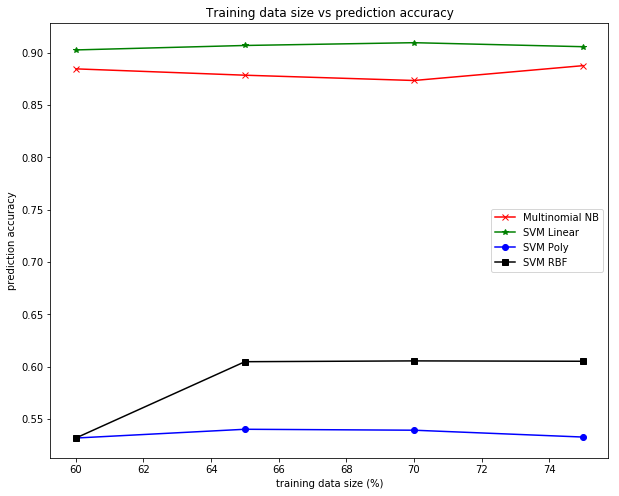

In [24]:
plt.figure(figsize=(10,8))
training_data_size = [60, 65, 70, 75]
plt.plot(training_data_size, accuracy_model_one, marker='x', color='r', label='Multinomial NB')
plt.plot(training_data_size, accuracy_model_two, marker='*', color='g', label='SVM Linear')
plt.plot(training_data_size, accuracy_model_three, marker='o', color='b', label='SVM Poly')
plt.plot(training_data_size, accuracy_model_four, marker='s', color='k', label='SVM RBF')
plt.xlabel('training data size (%)')
plt.ylabel('prediction accuracy')
plt.title('Training data size vs prediction accuracy')
plt.legend()